In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import mplfinance as mpf
import numpy as np
import scipy
from scipy.signal import savgol_filter
from scipy.cluster.hierarchy import ward, fcluster
from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.pyplot import axes
from pyparsing import alphas

C:\Users\daria\AppData\Local\Temp\ipykernel_5980\1024122561.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_x = data_10.append(data_11)
C:\Users\daria\AppData\Local\Temp\ipykernel_5980\1024122561.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data_x.append(data_12)


,timestamp,symbol,side,size,price,grossValue,homeNotional,foreignNotional
35505,2022-07-12 23:59:25,AAVEUSDT,Buy,7.00,68.35,4.784500e+10,7.00,478.450
35506,2022-07-12 23:59:28,AAVEUSDT,Buy,1.45,68.40,9.918000e+09,1.45,99.180
35507,2022-07-12 23:59:28,AAVEUSDT,Buy,7.00,68.40,4.788000e+10,7.00,478.800
35508,2022-07-12 23:59:28,AAVEUSDT,Buy,1.50,68.40,1.026000e+10,1.50,102.600
35509,2022-07-12 23:59:33,AAVEUSDT,Sell,0.01,68.40,6.840000e+07,0.01,0.684


In [ ]:
data_10 = pd.read_csv('AAVEUSDT2022-07-10.csv')
data_11 = pd.read_csv('AAVEUSDT2022-07-11.csv')
data_12 = pd.read_csv('AAVEUSDT2022-07-12.csv')
data_x = data_10.append(data_11)
data = data_x.append(data_12)
data = data.drop(['tickDirection', 'trdMatchID'], axis=1)
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
data.tail()

In [2]:
def show_filtered_data():
    filter = (data['timestamp'] >= '2022-07-10 00:30:00') & (data['timestamp'] <= '2022-07-10 00:31:00')
    data.loc[filter]

In [3]:
def mpf_plot_create():
    mpf.plot(minutly_price,style='yahoo', type='candle', volume=True)

In [4]:
def show_candlestick_chart(inner_data):
    fig = go.Figure(data=[go.Candlestick(
                x=inner_data.index.to_list(),
                open=inner_data['Open'],
                high=inner_data['High'],
                low=inner_data['Low'],
                close=inner_data['Close'])])

    fig.show()

In [5]:
minutly_price = data.groupby([pd.Grouper(
    key='timestamp', freq='min')]).agg(
        Open = ('price', 'first'),
        High = ('price', 'max'),
        Low = ('price', 'min'),
        Close = ('price', 'last'),
        Volume = ('size', 'sum'), ).round(2)
minutly_price.tail()

,Open,High,Low,Close,Volume
timestamp,,,,,
2022-07-12 23:55:00,68.35,68.35,68.30,68.30,42.38
2022-07-12 23:56:00,68.30,68.50,68.30,68.30,276.29
2022-07-12 23:57:00,68.25,68.30,68.25,68.25,348.39
2022-07-12 23:58:00,68.25,68.30,68.20,68.25,153.49
2022-07-12 23:59:00,68.30,68.40,68.30,68.40,83.51


In [6]:
rolling = minutly_price.rolling(window=100).mean()
rolling.tail()

,Open,High,Low,Close,Volume
timestamp,,,,,
2022-07-12 23:55:00,NaN,NaN,NaN,NaN,161.8313
2022-07-12 23:56:00,NaN,NaN,NaN,NaN,161.5257
2022-07-12 23:57:00,NaN,NaN,NaN,NaN,164.3973
2022-07-12 23:58:00,NaN,NaN,NaN,NaN,163.4514
2022-07-12 23:59:00,NaN,NaN,NaN,NaN,161.5865


In [7]:
show_candlestick_chart(minutly_price)

0.19951338199513388 65.8
82.2 65.8
[3478 3479 3480 3486]


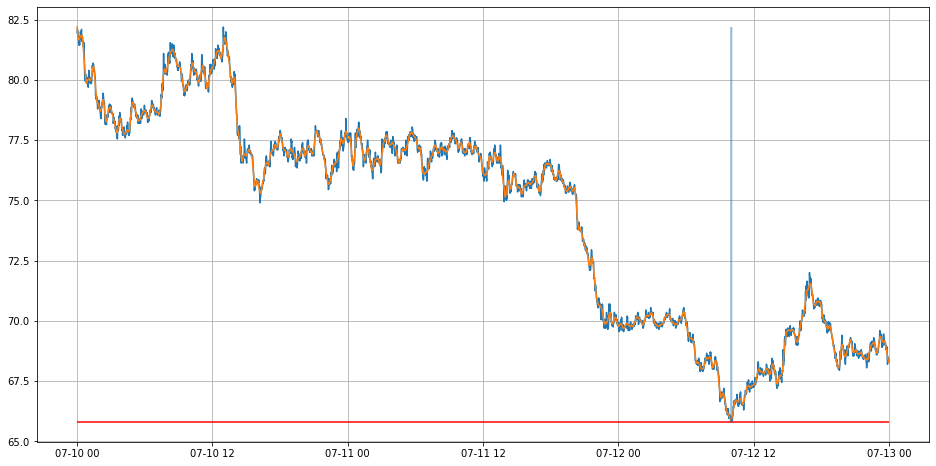

In [8]:
plt.figure(figsize=(16, 8))
plt.grid()

new_prices = minutly_price[:]
new_prices = new_prices.fillna(method="ffill")
#print(new_prices.isnull().sum())
p = np.array(new_prices['High'])
t = np.array(new_prices.index)
p_smoth = savgol_filter(p, 30, 3)

plt.plot(t, p)
plt.plot(t, p_smoth)

p_rolling = np.array(rolling['High'])
#plt.plot(t, p_rolling)

dpdt = np.diff(p)/1

#plt.plot(t[1:], dpdt+82)

maxi = []
val_max = []
val_min = []
indexes_max = []
indexes_min = []

for i in range(1, len(p)-1):
    if p[i] > p[i-1]:
        if p[i] > p[i+1]:
            val_max.append(p[i])
            indexes_max.append(i)

for i in range(0, len(p)-1):
    if p[i] < p[i-1]:
        if p[i] < p[i+1]:
            val_min.append(p[i])
            indexes_min.append(i)

a = np.where(dpdt == 0)

"""
plt.vlines(t[indexes_max], p.min(), p.max())
plt.vlines(t[indexes_min], p.min(), p.max(), color = 'r')
plt.vlines(t[a[0]], p.min(), p.max(), color = 'g')
"""

min_abs = np.min(val_min)

th = 0.005
diff_percent = (np.max(p) - np.min(p))/np.max(p)
print(diff_percent, min_abs)

b = np.where(p < diff_percent * th * np.mean(p) + min_abs)

print(np.max(p), np.min(p)) 
#plt.vlines(t[146], p.min(), p.max())
#plt.vlines(t[b], p.min(), p.max(), alpha=0.2)

if len(b[0]) >= 2:
    plt.hlines(min_abs, t.min(), t.max(), color = 'r')
    plt.vlines(t[b], p.min(), p.max(), alpha=0.2)
else:
    print("no support")

print(b[0])

For smooth values

no support


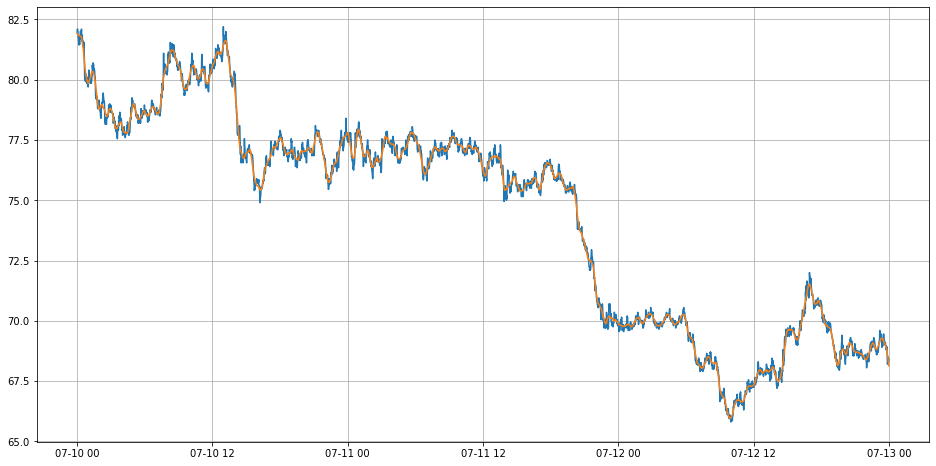

In [103]:
plt.figure(figsize=(16, 8))
plt.grid()

new_prices = minutly_price[:]
new_prices = new_prices.fillna(method="ffill")
new_prices = new_prices.fillna(method="bfill")
#print(new_prices.isnull().sum())
p = np.array(new_prices['High'])
t = np.array(new_prices.index)
p_smooth = savgol_filter(p, 50, 3)

plt.plot(t, p)
plt.plot(t, p_smooth)

val_max, val_min, indexes_max, indexes_min = [], [], [], []

for i in range(1, len(p_smooth)-1):
    if p_smooth[i] > p_smooth[i-1]:
        if p_smooth[i] > p_smooth[i+1]:
            val_max.append(p_smooth[i])
            indexes_max.append(i)

for i in range(0, len(p_smooth)-1):
    if p_smooth[i] < p_smooth[i-1]:
        if p_smooth[i] < p_smooth[i+1]:
            val_min.append(p_smooth[i])
            indexes_min.append(i)

min_abs = np.min(p)

th = 0.1
diff_percent = (np.max(p) - np.min(p))/np.max(p)

#print(diff_percent, min_abs)

b = np.where(val_min < diff_percent * th * np.mean(p_smooth) + min_abs)

#print(np.max(p_smooth), np.min(p_smooth)) 

if len(b[0]) >= 20:
    plt.hlines(min_abs, t.min(), t.max(), color = 'r')
    for i in b[0]:
        val = val_min[i]
        #print(val)
        index = np.where(p_smooth == val)
        plt.vlines(t[index], p.min(), p.max())
else:
    print("no support")

#print(new_prices)

Downhill algorithm

In [10]:
# silhouette method

def silhouette_coefficient(data):
    data_reshape = np.reshape(data, (-1, 1))

    scores = []
    coefficient = []
    
    for k in range(2,9):
        estimator = KMeans (n_clusters = k)
        estimator.fit(data_reshape)
        scores.append(silhouette_score(data_reshape,estimator.labels_,metric='euclidean'))
        coefficient.append(k)
    
    index_of_max = scores.index(max(scores))
    return coefficient[index_of_max]

threshold 1.485010156461526
max index: 22
len of maxs: 148
max level:  [61, 77.94464663461085]
cluster numbers:  2


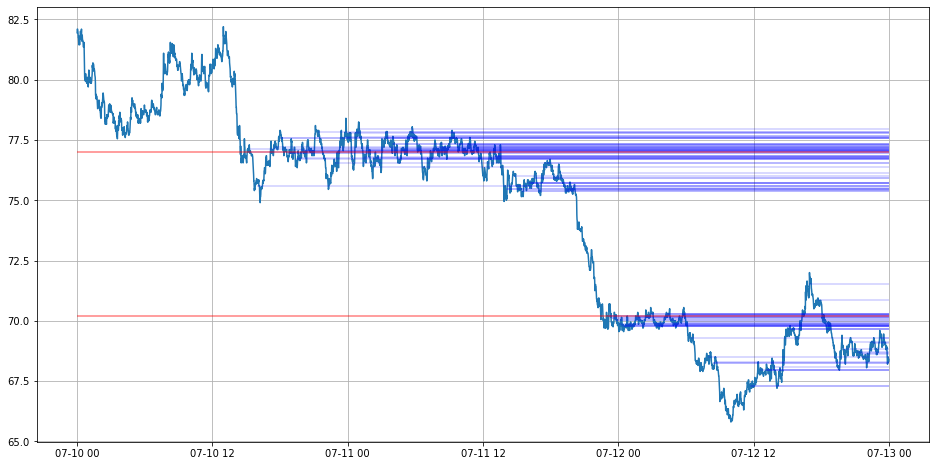

In [105]:
from matplotlib.pyplot import axes
from pyparsing import alphas

plt.figure(figsize=(16, 8))
plt.grid()

plt.plot(t, p)

#print(val_max[10])

th = 0.1
threshold = diff_percent * th * np.mean(p_smooth)
print("threshold", threshold)

touch = []
levels = []
level_prices = []
max_indexes = []

print("max index:", np.where(val_max == max(val_max))[0][0])
print("len of maxs:", len(val_max))

for i in val_max:
    #touch = np.where(i - val_max < diff_percent * th * np.mean(p_smooth) + min_abs)
    distance_to_level = abs(i - val_max)
    touch = np.where(distance_to_level < threshold)

    #if len(touch[0]) >= 10:
        #plt.hlines(i, t.min(), t.max(), color = 'b', alpha = 0.2)
        #levels.append([len(touch[0]), i])

max_index = np.where(val_max == max(val_max))[0][0]

for i in range(max_index, len(val_max)):
    distance_to_level = abs(val_max[i] - val_max)
    #print(distance_to_level)
    touch = np.where(distance_to_level < threshold)
    #print(threshold)

    if len(touch[0]) >= 15:
        index = np.where(p_smooth == val_max[i])[0]
        plt.hlines(val_max[i], t[index], t.max(), color = 'b', alpha = 0.2)
        levels.append([len(touch[0]), val_max[i]])
        level_prices.append(val_max[i])
        max_indexes.append(index)

#print((levels))
print("max level: ", max(levels, key = lambda x: x[1]))

level = max(levels, key = lambda x: x[1])
level_2 = max(levels, key = lambda x: x[0])

#plt.hlines(level[1], t.min(), t.max(), color = 'r')
#plt.hlines(level_2[1], t.min(), t.max(), color = 'g')

#clusters = np.histogram(level_prices, bins = 2)
#print(clusters)
cluster_numbers = silhouette_coefficient(level_prices)
print("cluster numbers: ", cluster_numbers)

if cluster_numbers <= 4:
    level_prices_reshape = np.reshape(level_prices, (-1, 1))

    kmeans = KMeans(n_clusters = cluster_numbers)
    kmeans.fit(level_prices_reshape)

    labels = kmeans.labels_
    for i in range(cluster_numbers):
        indexes = np.where(labels == i)[0]
        max_index = np.min(indexes)

        plt.hlines(level_prices[max_index], t.min(), t.max(), color = 'r', alpha = 0.5)
else:
    plt.hlines(level[1], t.min(), t.max(), color = 'r', alpha = 0.5)


#plt.hlines(kmeans.cluster_centers_, t.min(), t.max(), color = 'r', alpha = 0.2)

Pre finally version

C:\Users\daria\AppData\Local\Temp\ipykernel_5980\1329144300.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\daria\AppData\Local\Temp\ipykernel_5980\1329144300.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



threshold 2.883387053883407
max index: 112
len of maxs: 130
max level:  [69, 148.37749999999136]
cluster numbers:  3


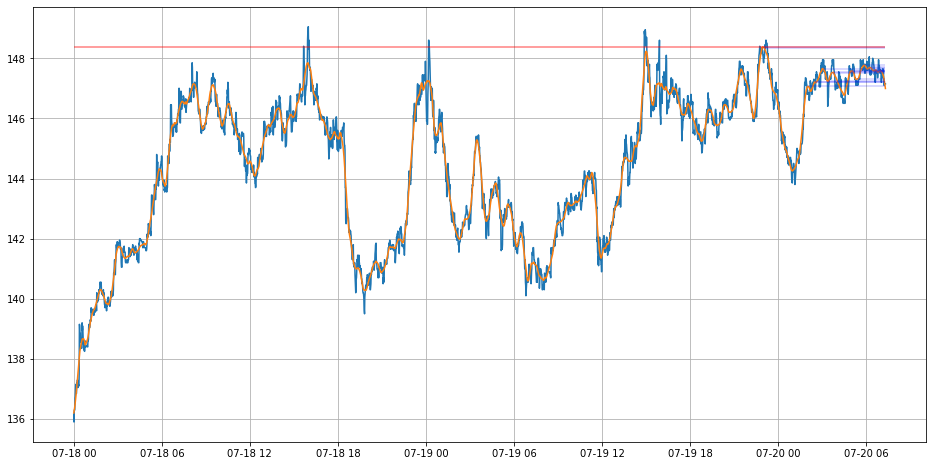

In [125]:
# open datasets and create dataframe
data_10 = pd.read_csv('XMRUSDT2022-07-18.csv')
data_11 = pd.read_csv('XMRUSDT2022-07-19.csv')
data_12 = pd.read_csv('XMRUSDT2022-07-20.csv')
data_x = data_10.append(data_11)
data = data_x.append(data_12)
data = data.drop(['tickDirection', 'trdMatchID'], axis=1)
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')

# gpouping data to tameframe
minutly_price = data.groupby([pd.Grouper(
    key='timestamp', freq='min')]).agg(
        Open = ('price', 'first'),
        High = ('price', 'max'),
        Low = ('price', 'min'),
        Close = ('price', 'last'),
        Volume = ('size', 'sum'), ).round(2)

# clearing nan-values
new_prices = minutly_price[:-1000]
new_prices = new_prices.fillna(method="ffill")
new_prices = new_prices.fillna(method="bfill")

# from dataframe to numpy array
p = np.array(new_prices['High'])
t = np.array(new_prices.index)

# smoothing
p_smooth = savgol_filter(p, 50, 3)

# plot create
plt.figure(figsize=(16, 8))
plt.grid()

# show raw and smooth plot
plt.plot(t, p)
plt.plot(t, p_smooth)

# searching local maximums
val_max, val_min, indexes_max, indexes_min = [], [], [], []

for i in range(1, len(p_smooth)-1):
    if p_smooth[i] > p_smooth[i-1]:
        if p_smooth[i] > p_smooth[i+1]:
            val_max.append(p_smooth[i])
            indexes_max.append(i)

for i in range(0, len(p_smooth)-1):
    if p_smooth[i] < p_smooth[i-1]:
        if p_smooth[i] < p_smooth[i+1]:
            val_min.append(p_smooth[i])
            indexes_min.append(i)

# set the threshold
th = 0.1
threshold = diff_percent * th * np.mean(p_smooth)
print("threshold", threshold)

# level touch count
touch = []
levels = []
level_prices = []
max_indexes = []

print("max index:", np.where(val_max == max(val_max))[0][0])
print("len of maxs:", len(val_max))

for i in val_max:
    distance_to_level = abs(i - val_max)
    touch = np.where(distance_to_level < threshold)

max_index = np.where(val_max == max(val_max))[0][0]

for i in range(max_index, len(val_max)):
    distance_to_level = abs(val_max[i] - val_max)
    touch = np.where(distance_to_level < threshold)

    if len(touch[0]) >= 15:
        index = np.where(p_smooth == val_max[i])[0]
        plt.hlines(val_max[i], t[index], t.max(), color = 'b', alpha = 0.2)
        levels.append([len(touch[0]), val_max[i]])
        level_prices.append(val_max[i])
        max_indexes.append(index)

level = max(levels, key = lambda x: x[1])
level_2 = max(levels, key = lambda x: x[0])

# clusters count
cluster_numbers = silhouette_coefficient(level_prices)
print("cluster numbers: ", cluster_numbers)

# one-cluster detection (if clusters > 2 -> cluster only one) 
# + show results
if cluster_numbers <= 2:
    level_prices_reshape = np.reshape(level_prices, (-1, 1))

    kmeans = KMeans(n_clusters = cluster_numbers)
    kmeans.fit(level_prices_reshape)

    labels = kmeans.labels_
    for i in range(cluster_numbers):
        indexes = np.where(labels == i)[0]
        max_index = np.min(indexes)

        plt.hlines(level_prices[max_index], t.min(), t.max(), color = 'r', alpha = 0.5)
else:
    plt.hlines(level[1], t.min(), t.max(), color = 'r', alpha = 0.5)

In [40]:
cluster = kmeans.labels_
n = np.where(cluster == 0)
n1 = np.where(cluster == 1)
print(n)
print(n1)
print("labels_:", kmeans.labels_)

print(np.max(level_prices_reshape[n]), np.min(level_prices_reshape[n]))

(array([49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
       66, 67, 68, 69, 70, 71, 72, 73, 74, 75], dtype=int64),)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
      dtype=int64),)
labels_: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
70.28895673076515 69.30278124999599


Choosing the optimal number of clusters

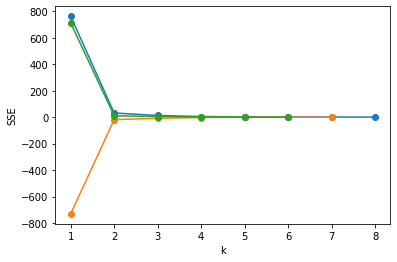

In [12]:
# elbow method

from sklearn.cluster import KMeans

estimator = KMeans (n_clusters = 2)

SSE = []
level_prices_reshape = np.reshape(level_prices, (-1, 1))

for k in range(1,9):
    estimator = KMeans (n_clusters = k)
    estimator.fit(level_prices_reshape)
    SSE.append(estimator.inertia_)

dSSEdn = np.diff(SSE)/1
dSSEdn_secondary = np.diff(dSSEdn)/1
    
X = range(1,9)
 
plt.xlabel('k')
 
plt.ylabel('SSE')
 
plt.plot(X,SSE,'o-')
plt.plot(X[:-1],dSSEdn,'o-')
plt.plot(X[:-2],dSSEdn_secondary,'o-')

plt.show()

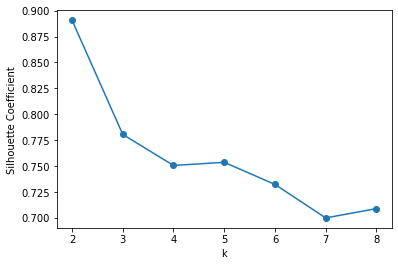

In [13]:
# silhouette method

from sklearn.metrics import silhouette_score

scores = []

for k in range(2,9):
    estimator = KMeans (n_clusters = k)
    estimator.fit(level_prices_reshape)
    scores.append(silhouette_score(level_prices_reshape,estimator.labels_,metric='euclidean'))

X = range(2,9)
 
plt.xlabel('k')
plt.ylabel('Silhouette Coefficient')
 
plt.plot(X,scores,'o-')
 
plt.show()

In [14]:
estimator = KMeans (n_clusters = 2)
estimator.fit(level_prices_reshape)
estimator.fit_predict(level_prices_reshape)
print(level_prices)
print(estimator.cluster_centers_)
print(estimator.fit_predict(level_prices_reshape))
print(estimator.fit_transform(level_prices_reshape))

[77.72893562425058, 77.13231257503087, 77.17514195678356, 77.13088160264184, 77.46835054021692, 77.54588685474273, 77.16601785714371, 77.16630687274998, 77.14650360144144, 77.15725570228182, 77.21434048619533, 77.21413940576318, 77.2285187575038, 76.93090621248577, 75.85201785714368, 75.84450150060108, 75.65653331332612, 75.8464339735903, 76.49131257503089, 75.56229501800804, 70.04209693877631, 70.0637957683081, 70.0823756002408, 70.08891326530687, 69.86205312124922, 69.86417091836815, 69.78503901560697, 69.79152010804394, 69.78674669868023, 69.97303181272584, 69.97282487995275, 69.99766146458659, 69.99807818127326, 70.0020976890764, 70.03509393757578, 70.0311745198087, 70.03385864345812, 70.21945558223362, 70.15762725090111, 70.15927971188549, 70.1411310024017, 68.29077085834408, 68.46834333733565, 67.94294312725162, 67.91751980792391, 67.91691176470663, 67.91524519808002, 68.00052250900436, 69.65160639255778, 69.39291356542695, 69.39575975390231, 69.39121488595516, 68.91578511404643,

Kmean clustering

In [15]:
level_prices_reshape = np.reshape(level_prices, (-1, 1))

kmeans = KMeans(n_clusters=2)
kmeans.fit(level_prices_reshape)
print(kmeans.cluster_centers_)

[[69.39725657]
 [76.83292961]]


In [16]:
# Импортируем библиотеки
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import pandas as pd

# Извлекаем измерения как массив NumPy
samples = level_prices

# Реализация иерархической кластеризации при помощи функции linkage
mergings = linkage(samples, method='complete')

# Строим дендрограмму, указав параметры удобные для отображения
dendrogram(mergings,
           labels=varieties,
           leaf_rotation=90,
           leaf_font_size=6,
           )

plt.show()

ValueError: Length n of condensed distance matrix 'y' must be a binomial coefficient, i.e.there must be a k such that (k \choose 2)=n)!

Derivative test

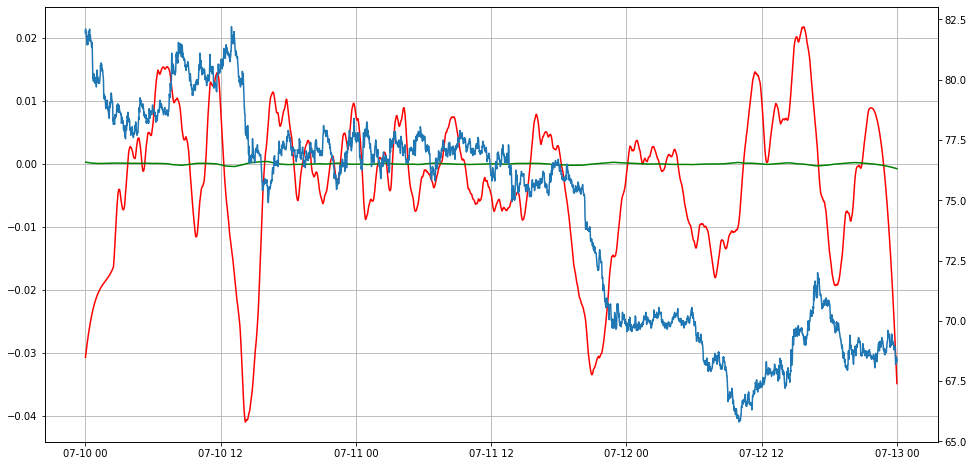

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
ax1 = ax.twinx()

ax.grid()

new_prices = minutly_price[:]
new_prices = new_prices.fillna(method="ffill")

p = np.array(new_prices['High'])
t = np.array(new_prices.index)
p_smooth = savgol_filter(p, 50, 3)

ax1.plot(t, p)
#ax1.plot(t, p_smooth)

smooth_k = 300

dpdt = np.diff(p_smooth)/1
dpdt_smooth = savgol_filter(dpdt, smooth_k, 3)

dpdt_second = np.diff(dpdt_smooth)/1
dpdt_second_smooth = savgol_filter(dpdt_second, smooth_k, 3)

ax.plot(t[1:], dpdt_smooth, color = 'r')
ax.plot(t[2:], dpdt_second_smooth, color = 'g')

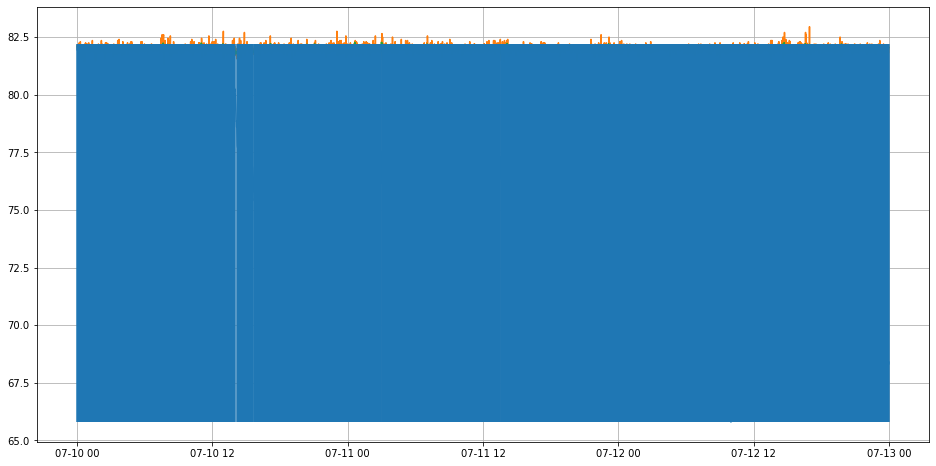

In [ ]:
limit = 0.1
plt.figure(figsize=(16, 8))
plt.grid()

dpdt = np.diff(p)/1

dpdt_smoth = savgol_filter(dpdt, 10, 3)

b = np.where((dpdt_smoth <= limit) & (dpdt_smoth >= -limit))
#a = np.where(b[0] > -0.001)

#print(dpdt_smoth)
#print(b)
#print(dpdt_smoth[b[0]])

plt.plot(t, p)
plt.plot(t[1:], dpdt+82)
plt.plot(t[1:], dpdt_smoth+82)
plt.vlines(t[b[0]], p.min(), p.max())

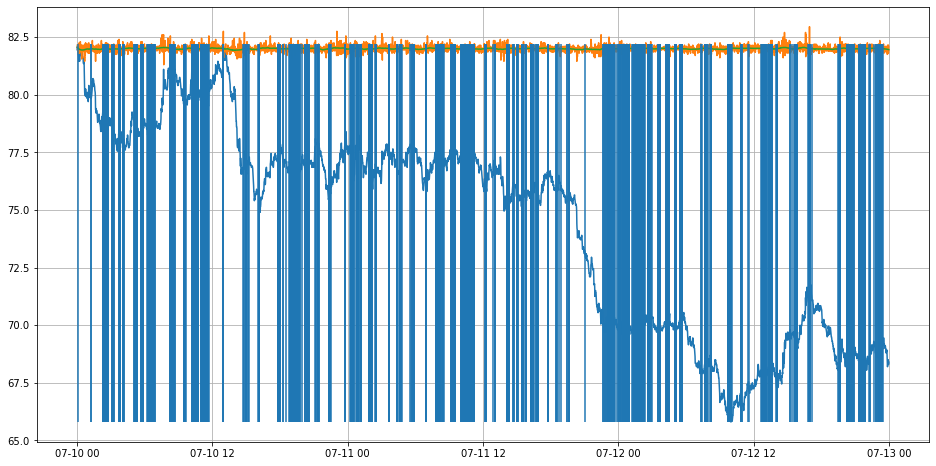

In [ ]:
limit = 0.005
plt.figure(figsize=(16, 8))
plt.grid()

dpdt = np.diff(p)/1

dpdt_smoth = savgol_filter(dpdt, 100, 3)

b = np.where((dpdt_smoth <= limit) & (dpdt_smoth >= -limit))
#a = np.where(b[0] > -0.001)

#print(dpdt_smoth)
#print(b)
#print(dpdt_smoth[b[0]])

plt.plot(t, p)
plt.plot(t[1:], dpdt+82)
plt.plot(t[1:], dpdt_smoth+82)
plt.vlines(t[b[0]], p.min(), p.max())

[ 0.15  0.15  0.   -0.05 -0.05 -0.15 -0.1   0.   -0.2  -0.1 ]
[ 0.15  0.   -0.05 -0.05 -0.15 -0.1   0.   -0.2  -0.1   0.1 ]
[ 8.52096171e-15  1.50000000e-01  5.00000000e-02  0.00000000e+00
  1.00000000e-01 -5.00000000e-02 -1.00000000e-01  2.00000000e-01
 -1.00000000e-01 -2.00000000e-01]


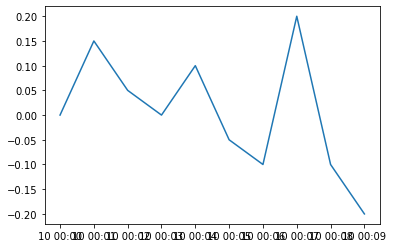

In [ ]:
dpdt = np.diff(p)/1
dpdt_right_shift = [0.15]
b = np.append(dpdt_right_shift, dpdt[:9], axis=None)

print(b)
print(dpdt[:10])
a = b - dpdt[:10]
print(a)
plt.plot(t[:10], a)

In [ ]:
hourly_price = data.groupby([pd.Grouper(
    key='timestamp', freq='H')]).agg(
        High = ('price', 'max'),
        Low = ('price', 'min'),
        Open = ('price', 'first'),
        Close = ('price', 'last'),
        Volume = ('size', 'sum'), ).round(2)
hourly_price.head(24)

,High,Low,Open,Close,Volume
timestamp,,,,,
2022-07-10 00:00:00,82.10,79.45,81.80,79.60,43072.77
2022-07-10 01:00:00,80.70,78.55,79.65,78.65,43319.46
2022-07-10 02:00:00,79.45,77.15,78.65,78.85,31518.30
2022-07-10 03:00:00,78.90,77.45,78.80,77.85,23232.52
2022-07-10 04:00:00,79.25,77.35,77.80,78.90,26194.27
2022-07-10 05:00:00,79.00,78.05,78.85,78.70,15846.35
2022-07-10 06:00:00,79.15,78.15,78.70,78.60,10415.79
2022-07-10 07:00:00,81.10,78.40,78.60,80.25,33342.11
2022-07-10 08:00:00,81.55,80.05,80.20,80.50,29152.15


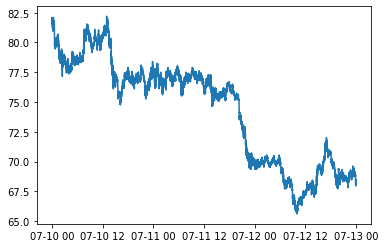

In [ ]:
plt.plot(data.timestamp, data.price)